In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
import cartopy.crs as ccrs
from shared_astro_utils import matching_utils
from astropy import units as u

In [2]:
os.chdir('/home/walml/repos/zoobot')

# Conclusions

So far, I think
- GZ2 had r < 17.0 mag cut, while DECALS did not (there are many galaxies down to r~17.8, and a few even fainter).

And with respect to the catalogs themselves, GZ2 was selected from the DR7 Legacy catalog, which is not quite the same as the NSA catalog:
- The NSA catalog (our version) is from DR11, which included about 2500 sq deg added in DR8. So the Sloan footprint expanded post-GZ2 (effectively), and the galaxies in the new footprint are new in DECALS
- There remains about 70,000 galaxies which are new in the NSA catalog but not in GZ2, despite passing the magnitude and radius cuts, and I'm not sure why. About half are ultimately included for the first time in DECALS.


Relatedly, ~10% of the galaxies in DR7 Legacy (via GZ2) are not in the NSA catalog. This is because the NSA catalog only includes z < 0.15, while GZ2 includes up to z < 0.25. This doesn't add any new DECALS galaxies, though.

This explains most of the new galaxies (about 45% from the dropped magnitude cut, about 10% from the new sky coverage, and about 10% from the mysterious new NSA galaxies, matching the roughly 2/3rds of DECALS galaxies not previously classified in GZ2)

https://skyserver.sdss.org/CasJobs/SubmitJob.aspx#
http://skyserver.sdss.org/CasJobs/Guide.aspx
http://skyserver.sdss.org/dr7/en/help/browser/browser.asp View -> Galaxies
For query, see keep. Note - not quite the same as no redshifts. Waiting for help from GZ channel, hoepfully they just have the table. 

Alternatively, Steven might.
https://www.jiscmail.ac.uk/cgi-bin/webadmin?A2=ind0807&L=GZTEAM&P=R38334&X=A8F39DFFB4E7DEE177&Y=walmsleymk1%40gmail.com
http://research.icg.port.ac.uk/wikis/galaxyzoo/GZ_2.0_sample_construction (but needs login)


# Load data and viz. coverage

### NSA

In [3]:

nsa_catalog_loc = 'data/nsa_v1_0_1.fits'

physical_cols = ['SERSIC_ABSMAG', 'MAG', 'Z', 'SERSIC_MASS', 'SERSIC_NMGY', 'PETRO_BA50', 'PETRO_BA90', 'PETRO_TH90', 'PETRO_THETA', 'CLUMPY', 'ASYMMETRY']
cols_to_load = ['RA', 'DEC'] + physical_cols
nsa_catalog = Table.read(nsa_catalog_loc)[cols_to_load]

for col in cols_to_load:
    nsa_catalog[col.lower()] = nsa_catalog[col]
    del nsa_catalog[col]


In [4]:
nsa_catalog['asymmetry_r'] = nsa_catalog['asymmetry'][:, 4]
nsa_catalog['clumpy_r'] = nsa_catalog['clumpy'][:, 4]
nsa_catalog['sersic_absmag_r'] = nsa_catalog['sersic_absmag'][:, 4]
nsa_catalog['sersic_nmgy_r'] = nsa_catalog['sersic_nmgy'][:, 4]
del nsa_catalog['asymmetry']
del nsa_catalog['clumpy']
del nsa_catalog['sersic_absmag']
del nsa_catalog['sersic_nmgy']

In [5]:
    
nsa_catalog = nsa_catalog.to_pandas()

In [6]:
def get_mag(flux):  # pogson, will only match at decent SNR
    return 22.5 - 2.5 * np.log10(flux + 1e-10)

In [7]:
nsa_catalog['mag_r'] = get_mag(nsa_catalog['sersic_nmgy_r'])

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


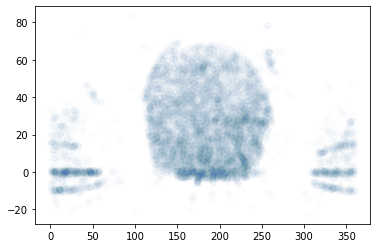

In [8]:
nsa_catalog_s = nsa_catalog.sample(10000)
ax = plt.subplot()
ax.scatter(x=nsa_catalog_s['ra'], y=nsa_catalog_s['dec'], alpha=0.01)

NSA is derived from DR11 (https://www.sdss.org/dr13/manga/manga-target-selection/nsa/), which includes the extra 2500 sq deg added at the SGC. 

> The principal change in the imaging footprint from that in DR7 is the coverage of a large contiguous region, 3172 deg2, in the southern Galactic cap. Three disjoint stripes (76, 82, and 86, centered roughly at α = 0h, δ = −10°, 0°, and +15°, respectively) were included in DR7. The remaining area, roughly 2500 deg2, was observed in the Fall and early Winter months of 2008 and 2009; it will be used to identify spectroscopic targets for the BOSS survey

https://iopscience.iop.org/article/10.1088/0067-0049/193/2/29/meta#apjs385902s5 Section 2. The 'edge areas' above correspond to the smaller circle (near RA=0) on Fig 1. GZ2 only includes stripe82, the stripe around dec=0. The other stripes were for SEGUE and (for some reason) not included, as stated in the GZ2 DR (2.1 paragraph 1)

### DECALS DR1/DR2

In [9]:
dr1_dr2 = pd.read_csv('/media/walml/beta/decals/catalogs/decals_dr1_and_dr2.csv')
dr1_dr2_s = dr1_dr2.sample(10000)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


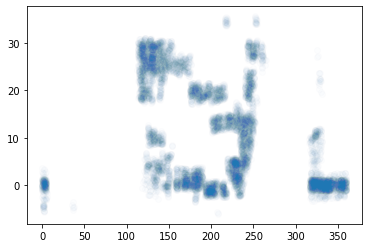

In [10]:
ax = plt.subplot()
ax.scatter(x=dr1_dr2_s['ra'], y=dr1_dr2_s['dec'], alpha=0.01)

DR1/2 were quite early in the DECALS program and so have patchy coverage. The footprint becomes clearer below.

### DECALS DR5 (and below)

In [19]:
# decals_master = pd.read_csv('/media/walml/beta/decals/catalogs/decals_master_catalog.csv')
decals_master = Table.read('/media/walml/beta/decals/catalogs/nsa_v1_0_0_decals_dr5.fits').to_pandas()
decals_master['iauname'] = decals_master['iauname'].str.decode('utf8')

In [20]:
decals_master

,iauname,nsa_id,ra,dec,petrotheta,petroth50,petroth90,z,nsa_version
0,J094651.40-010228.5,0,146.714215,-1.041280,7.247893,3.464192,10.453795,0.021222,b'1_0_0'
1,J094630.85-004554.5,1,146.628585,-0.765162,5.617822,2.326989,6.721991,0.064656,b'1_0_0'
2,J094631.59-005917.7,2,146.631706,-0.988347,4.769891,2.278736,5.177910,0.052654,b'1_0_0'
3,J094744.18-004013.4,3,146.934129,-0.670405,6.243227,2.655191,9.177605,0.121270,b'1_0_0'
4,J094751.74-003242.0,4,146.963500,-0.544776,8.891541,4.383704,10.253274,0.055981,b'1_0_0'
...,...,...,...,...,...,...,...,...,...
343123,J230924.60-001458.1,698646,347.352267,-0.249637,7.473316,3.746857,8.638098,0.116300,b'1_0_0'
343124,J235101.08-100042.7,698661,357.755712,-10.010851,17.017670,7.430995,19.937094,0.074300,b'1_0_0'
343125,J235247.10-105259.6,698664,358.197549,-10.883763,17.845497,8.614392,18.517103,0.076100,b'1_0_0'
343126,J235320.91-103238.7,698665,358.336971,-10.544118,5.330101,2.929065,7.437321,0.077100,b'1_0_0'


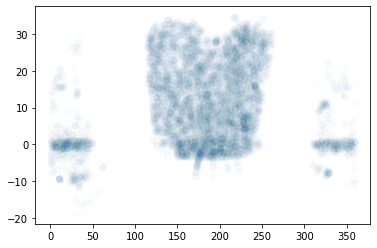

In [22]:

decals_master_s = decals_master.sample(10000)
ax = plt.subplot()
ax.scatter(x=decals_master_s['ra'], y=decals_master_s['dec'], alpha=0.01)

The DR5 footprint is simply the intersection of the NSA catalog (above, from SDSS DR8-11) and the DECALS imaging. DECALS imaged the SDSS footprint below dec=30, including the new 'wings' of the SGC. It's clearer below.

### GZ2

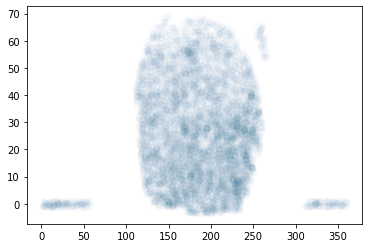

In [23]:
gz2 = pd.read_csv('data/gz2/gz2_classifications_and_subjects.csv', usecols=['ra', 'dec', 'dr7objid'])
gz2_s = gz2.sample(10000)
ax = plt.subplot()
ax.scatter(x=gz2_s['ra'], y=gz2_s['dec'], alpha=0.01)

GZ2 was constructed from SDSS DR7 Legacy Catalog (which I'm still trying to get my hands on). This was before the SGC region was added, so it only includes the NGC footprint and stripe82.

## Direct Comparisons and Summary

We can see that:
- NSA has similar coverage to GZ2, but adds the extra galaxies around SGC outside of stripe82 (seen in blue)
- DECALS imaged the dec < 30 portion of the NSA catalog, missing the 'top' of the SDSS footprint but including the DR8 'wings'

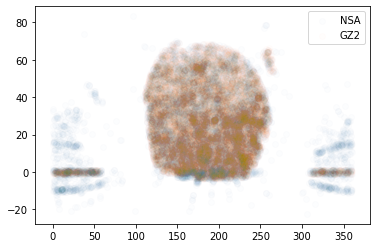

In [24]:
ax = plt.subplot()
ax.scatter(x=nsa_catalog_s['ra'], y=nsa_catalog_s['dec'], alpha=0.01, label='NSA')
ax.scatter(x=gz2_s['ra'], y=gz2_s['dec'], alpha=0.01, label='GZ2')
# ax.scatter(x=decals_master['ra'], y=decals_master['dec'], alpha=0.01, label='DECaLSxNSA')
ax.legend()

Text(0, 0.5, 'Dec')

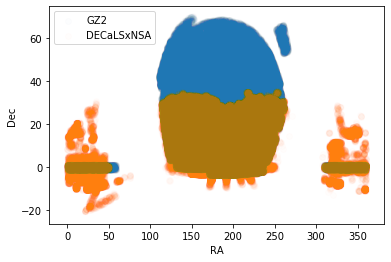

In [25]:
ax = plt.subplot()
# ax.scatter(x=s['ra'], y=s['dec'], alpha=0.01, label='NSA')
ax.scatter(x=gz2['ra'], y=gz2['dec'], alpha=0.01, label='GZ2')
ax.scatter(x=decals_master['ra'], y=decals_master['dec'], alpha=0.01, label='DECaLSxNSA')
ax.legend()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

So the new southern cap galaxies in DR8/NSA (about 2500 sq deg added to 10k sq deg) will mostly be new (except the equatorial stripe)

In [26]:
np.mean((decals_master['ra'] < 100) | (decals_master['ra'] > 300 ))

0.14226469422489565

So up to 14% of the DECALS galaxies will be new due to the extra SGC coverage

## How many new galaxies do we actually have in DECALS?

In [27]:
decals_gz2, decals_not_gz2 = matching_utils.match_galaxies_to_catalog_pandas(decals_master, gz2)
len(decals_gz2), len(decals_not_gz2), len(decals_gz2)/len(decals_master)

(126225, 216903, 0.3678656361474435)

Roughly two thirds of the DECALS galaxies were new i.e. not already classified in GZ2. This is a lot more than just the extra coverage, so let's look deeper.

Note that this is actually the master catalog, not joint catalog, and I need to update this - see decals prep notebook

# Effect of Selection Cuts

The above is all about comparing footprints of catalogs, before selection cuts on which galaxies to upload. Let's apply those next.

Stephen has a version of GZ1+ matched to the sloan data, so let's use that so that we can compare the magnitudes, radii, etc of GZ2 with DECALS (for which we have the NSA catalog)

In [28]:
gz_extra = Table.read('/media/walml/beta/galaxy_zoo/gz2/GalaxyZoo1_DR_extra.fits').to_pandas()

In [29]:
for col in gz_extra.columns.values:
    gz_extra[col.lower()] = gz_extra[col]
    del gz_extra[col]

In [30]:
gz_extra

,objid,u,g,r,i,z,uerr,gerr,rerr,ierr,...,mi_model,mz_model,muerr_model,mgerr_model,mrerr_model,mierr_model,mzerr_model,cur,logmstar_baldry06,redness_baldry06
0,587722952230174996,19.008148,17.912445,17.412403,17.208168,16.912600,0.122399,0.018222,0.017560,0.022389,...,-18.363708,-18.525042,0.056204,0.013570,0.013283,0.014290,0.028984,1.495525,9.032605,-0.344565
1,587722952230175035,18.606010,17.641466,17.206310,16.916487,16.764717,0.101442,0.015063,0.012843,0.021500,...,-20.909492,-21.131071,0.057379,0.012921,0.012488,0.012986,0.024997,1.573725,10.013254,-0.498963
2,587722952230175138,18.433449,17.568390,16.839195,16.562235,16.380388,0.127924,0.020576,0.017179,0.021322,...,-23.053547,-23.384979,0.091384,0.014572,0.012863,0.013197,0.023625,1.981333,11.080755,-0.482437
3,587722952230175145,18.627724,17.253843,16.629980,16.291378,16.065838,0.109365,0.011385,0.009781,0.011814,...,-21.318966,-21.593426,0.057043,0.012035,0.011418,0.011532,0.017500,1.985682,10.408378,-0.259986
4,587722952230175173,18.479033,16.985634,16.426798,16.048992,15.823992,0.116059,0.012274,0.010662,0.011516,...,-21.613138,-21.935856,0.057226,0.011839,0.011266,0.011264,0.015929,2.079020,10.558182,-0.229073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667939,588848901538578615,19.209692,17.820307,16.878048,16.503515,16.204014,0.140688,0.014020,0.009637,0.010929,...,-22.222851,-22.501530,0.058655,0.012516,0.011447,0.011553,0.015926,2.125961,10.856397,-0.284094
667940,588848901538775274,19.147995,18.117113,17.687269,17.406347,17.250843,0.106371,0.015247,0.012148,0.019987,...,-19.517204,-19.657061,0.057815,0.013180,0.012760,0.013620,0.028451,1.545130,9.490784,-0.361763
667941,588848901538906248,20.694366,18.656750,17.613506,17.248978,16.932396,0.299413,0.027289,0.011427,0.014231,...,-21.587961,-21.866100,0.119082,0.013720,0.011778,0.012038,0.017776,2.778126,10.670746,0.427572
667942,588848901539430566,17.228622,16.270767,15.908384,15.727290,15.497869,0.037042,0.009608,0.009028,0.009575,...,-19.557774,-19.724171,0.026262,0.010775,0.010743,0.010970,0.014573,1.338152,9.391127,-0.548958


In [31]:
gz2['objid'] = gz2['dr7objid']

In [32]:
gz2_extra = pd.merge(gz_extra, gz2, how='inner', on='objid', suffixes=('_extra', ''))
len(gz2_extra), len(gz2)  # perfect match, good job Stephen.

(239695, 239695)

In [33]:
decals_gz2, decals_not_gz2 = matching_utils.match_galaxies_to_catalog_pandas(decals_master, gz2_extra)
len(decals_gz2), len(decals_not_gz2)

(126225, 216903)

In [34]:
decals_nsa, decals_not_nsa = matching_utils.match_galaxies_to_catalog_pandas(decals_master, nsa_catalog)
len(decals_nsa), len(decals_not_nsa)

(343128, 0)

In [35]:
gz2_nsa, gz2_not_nsa = matching_utils.match_galaxies_to_catalog_pandas(gz2, nsa_catalog)
len(gz2_nsa), len(gz2_not_nsa)

(218759, 20936)

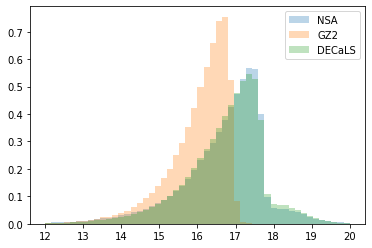

In [36]:
fig, ax = plt.subplots()
alpha = .3
bins = 30
_, bins = np.histogram(np.linspace(12, 20), bins=50)
ax.hist(nsa_catalog[~np.isinf(nsa_catalog['mag_r'])]['mag_r'], bins=bins, alpha=alpha, density=True, label='NSA')
# ax.hist(-gz_extra['r'], bins=30, alpha=alpha, density=True)
ax.hist(gz2_nsa[~np.isinf(gz2_nsa['mag_r'])]['mag_r'], bins=bins, alpha=alpha, density=True, label='GZ2')
ax.hist(decals_nsa[~np.isinf(decals_nsa['mag_r'])]['mag_r'], bins=bins, alpha=alpha, density=True, label='DECaLS')
plt.legend()

GZ2 has a cut of r < 17, as stated in DR paper (Section 2). But DECALS *has no magnitude cut made by us*. This means DECALS includes a bunch of faint r > 17 galaxies that, even if they been in the DR7 footprint, would not have been selected for GZ2.

In [37]:
(decals_nsa['mag_r'] > 17).mean()

0.46020726959035696

In [38]:
np.mean((decals_nsa['ra'] < 100) | (decals_nsa['ra'] > 300 ))

0.14226469422489565

In [39]:
np.mean((decals_nsa['ra'] < 100) | (decals_nsa['ra'] > 300 ) | (decals_nsa['mag_r'] > 17))

0.5379391947028515

About 45% of the DECALS galaxies are fainter than r = 17, and 55% are either faint or in the new 'wings' area. That's now very close to explaining the 65% new galaxies.

In [40]:
# using decals_nsa instead of decals_master here for the catalog info, it's a perfect match so equivalent
decals_gz2, decals_not_gz2 = matching_utils.match_galaxies_to_catalog_pandas(decals_nsa, gz2_extra, matching_radius=20*u.arcsec)
len(decals_gz2), len(decals_not_gz2)

(127034, 216094)

In [41]:
decals_not_gz2 = decals_not_gz2.query('mag_r < 17')
decals_not_gz2 = decals_not_gz2.query('ra > 100')
decals_not_gz2 = decals_not_gz2.query('ra < 300')
print(len(decals_not_gz2))

39269


Nice, nearly all the new galaxies explained.

There are three more plausible reasons to have galaxies in DECALS but not in GZ2:
- The radii cut changed from SDSS petroR90_r > 3 to NSA PETROTHETA > 3
- The cut for bad SDSS flags was dropped 
- Re-run of the source identification pipeline between DR7-DR8 (according to Karen)

To check these I need the original DR7 catalog prior to applying these cuts, which I don't have.

## Side Note - GZ2 galaxies not in DECALS

In [ ]:
gz2_nsa, gz2_not_nsa = matching_utils.match_galaxies_to_catalog_pandas(gz2_extra, nsa_catalog, matching_radius=20*u.arcsec)

In [ ]:
len(gz2_nsa), len(gz2_not_nsa)

In [ ]:
gz2_nsa_s = gz2_nsa.sample(10000)
gz2_not_nsa_s = gz2_not_nsa.sample(10000)
ax = plt.subplot()
ax.scatter(x=gz2_nsa_s['ra'], y=gz2_nsa_s['dec'], alpha=0.01, label='GZ2_NSA')
# ax.scatter(x=gz2['ra'], y=gz2['dec'], alpha=0.01, label='GZ2')
ax.scatter(x=gz2_not_nsa_s['ra'], y=gz2_not_nsa_s['dec'], alpha=0.01, label='GZ2_notNSA')
ax.legend()

In [ ]:
gz2_not_nsa['redshift'].hist(alpha=.5)
gz2_nsa['redshift'].hist(alpha=.5)

In [ ]:
len(gz2_not_nsa.query('redshift < .15'))

Of the 20,000 GZ2 galaxies not in the NSA, most can be explained by the different redshift cuts. GZ2 includes z < 0.25, while the NSA only goes to z < 0.15.

I don't know what happened to the remaining 7000 though. Perhaps the source detection and deblending code gave different results for these candidate objects.

## Side Note - Not all new NSA galaxies are in DECALS, because (of course) they might not be imaged.

In [ ]:
nsa_gz2, nsa_not_gz2 = matching_utils.match_galaxies_to_catalog_pandas(nsa_catalog, gz2_extra, matching_radius=20*u.arcsec)

In [ ]:
new_nsa_in_decals, new_nsa_not_decals = matching_utils.match_galaxies_to_catalog_pandas(nsa_not_gz2, decals_master, matching_radius=20*u.arcsec)

In [ ]:
len(new_nsa_in_decals), len(new_nsa_not_decals)  # why not all in decals?

In [ ]:
new_nsa_not_decals.columns.values

In [ ]:
# _, bins = np.histogram(np.linspace(0., 40.), bins=40)
bins=40
new_nsa_in_decals['dec'].hist(bins=bins, alpha=.5)
new_nsa_not_decals['dec'].hist(bins=bins, alpha=.5)


In [ ]:
plt.figure()
ax = plt.subplot()
ax.scatter(x=new_nsa_in_decals['ra'], y=new_nsa_in_decals['dec'], alpha=0.003, label='NSA_notGZ2_DECALS')
# ax.scatter(x=new_nsa_not_decals['ra'], y=new_nsa_not_decals['dec'], alpha=0.003, label='NSA_notGZ2_notDECALS')
ax.legend()

In [ ]:
plt.figure()
ax = plt.subplot()
ax.scatter(x=new_nsa_not_decals['ra'], y=new_nsa_not_decals['dec'], alpha=0.003, label='NSA_notGZ2_notDECALS')
ax.legend()

New galxies are included if within the 0-30 deg dec footprint of decals

In [ ]:
_, bins = np.histogram(np.linspace(0., 40.), bins=40)
new_nsa_in_decals['petro_theta'].hist(bins=bins, alpha=.5)
new_nsa_not_decals['petro_theta'].hist(bins=bins, alpha=.5)


In [ ]:
len(nsa_gz2), len(nsa_not_gz2)

In [ ]:
matched[~np.isinf(matched['mag_r'])]['mag_r'].hist(bins=30)

In [ ]:
ax = plt.subplot(projection="mollweide")
ax.scatter(x=-np.pi/2+2*np.pi*s['ra']/360., y=2*np.pi*s['dec']/360)

In [ ]:
# s = nsa_catalog.sample(10000)
# ax = plt.axes(projection=ccrs.Mollweide())
# ax.set_global()
# # ax.stock_img()
# # ax = plt.subplot(projection="mollweide")
# # ax.scatter(x=s['ra'], y=s['dec'])
# ax.scatter(12000000., 5000000.)
# # ra = np.random.uniform(low=-np.pi/3., high=np.pi/3., size=1000)
# # dec = np.random.uniform(low=-np.pi/3, high=np.pi/3, size=1000)
# # ax.scatter(ra, dec)
# # ax.set_xlabel("RA")
# # ax.set_ylabel("Dec")